<a href="https://colab.research.google.com/github/jimbrig-work/Collab-Notebooks/blob/main/LTC_ClaimTermination_BigQuery_Latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CLAIM TERMINATIONS STUDY**


In [ ]:
import io

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras.losses import Loss
from tensorflow.python.keras.utils.vis_utils import plot_model

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
_EPSILON = 1e-08

##### USER-DEFINED FUNCTIONS
def log(x):
    return tf.math.log(x + _EPSILON)

def div(x, y):
    return tf.div(x, (y + _EPSILON))

## Authenticate with GCP Bigquery

In [4]:
# OAuth Method
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


**Specify Project ID**

In [3]:
project_id = 'pg-us-e-app-584489'

**Run a Query**

In [5]:
# example query retrieving total rows:
%%bigquery --project pg-us-e-app-584489
SELECT 
  COUNT(*) as total_rows
FROM `Equitable.ProRata`

,total_rows
0,26425235


**Enable data table display**

In [ ]:
%load_ext google.colab.data_table

If you would prefer to return to the classic Pandas dataframe display, you can disable this by running:

In [ ]:
%unload_ext google.colab.data_table

# I. Data Prep

**Load and Preprocess the Dataset**

Load Data (Disabling Full load and Sampling 250,000 Rows:

In [6]:
# Load Full Data from Big Query and Assign to df and display output
# Commenting out cause too big:
# %%bigquery --project pg-us-e-app-584489 df
# SELECT * FROM `Equitable.ProRata`

from google.cloud import bigquery

client = bigquery.Client(project=project_id)

sample_count = 250000
row_count = client.query('''
  SELECT 
    COUNT(*) as total
  FROM `Equitable.ProRata`''').to_dataframe().total[0]

df = client.query('''
  SELECT
    *
  FROM
    `Equitable.ProRata`
  WHERE RAND() < %d/%d
''' % (sample_count, row_count)).to_dataframe()

print('Full dataset has %d rows' % row_count)

Full dataset has 26425235 rows


### Examine Loaded Data

In [7]:
# Describe the Data
df.describe()
print(df.shape)
df.head(10)

(249990, 28)


,int64_field_0,Year_curr,Month_curr,curr_ss_date,Q,Life_Benefit,With_Map,ITMband,product,product_series,legacy_nonleg,Buyout_Indicator,db_benefit,tax_status,channel,pt_nlg_ind,Withdrawal_Taken,ProRata_ind,Rate_ib_db,AAge_band,Venerable_Ind,_49_1_Indicator,Inforce,Inforce_AV,Inforce_BB,Expected_Pro_Rata_Amount,Actual_Pro_Rata_Amount,Expected
0,7069092,2017.0,8.0,2017-08-31,2017Q3,DB_Only,Other,10% to 20%,ACC,ACC_1995/1996,Legacy,No_Buyout,RAT/ROP,Q,R,False,0.0,0,6.0,81.0,EQH,EQH,1,27733.25,0.00,118.306347,0.0,RWST
1,8089499,2017.0,8.0,2017-08-31,2017Q3,GMIB,Other,10% to 20%,ACC,ACC_Stylus,Legacy,No_Buyout,MAX/RU,Q,W,True,0.0,0,6.5,73.0,EQH,EQH,1,116078.49,197205.98,40.142844,0.0,STAT
2,6167791,2017.0,8.0,2017-08-31,2017Q3,GMIB,Other,0% to 10%,ACC,ACC_Stylus,Legacy,No_Buyout,MAX/RU,NQ,W,True,0.0,0,6.5,62.0,EQH,EQH,1,62102.32,88022.12,18.801477,0.0,GAAP
3,18185720,2019.0,1.0,2019-01-31,2019Q1,DB_Only,Other,-50% to -30%,ACC,ACC_1995/1996,Legacy,No_Buyout,RAT/ROP,NQ,R,False,0.0,0,6.0,86+,EQH,EQH,1,99053.28,0.00,0.000000,0.0,Actual
4,17251902,2019.0,1.0,2019-01-31,2019Q1,GMIB,Other,-30% to -20%,ACC,ACC_Stylus,Legacy,No_Buyout,MAX/RU,Q,W,True,0.0,0,6.5,74.0,EQH,EQH,1,78243.73,99465.31,98.533633,0.0,STAT
5,16270596,2019.0,1.0,2019-01-31,2019Q1,GMIB,Other,-50% to -30%,ACC,ACC_Stylus,Legacy,No_Buyout,MAX/RU,Q,W,True,0.0,0,6.0,70.0,EQH,EQH,1,90342.99,104401.18,62.975463,0.0,RWST
6,16306493,2019.0,1.0,2019-01-31,2019Q1,GMIB,Other,50% to 60%,ACC,ACC_Stylus,Legacy,No_Buyout,MAX/RU,Q,W,True,1.0,0,6.0,76.0,EQH,EQH,1,25357.58,89779.69,6.847075,0.0,RWST
7,15297266,2019.0,1.0,2019-01-31,2019Q1,GMIB,Other,-30% to -20%,ACC,ACC_Stylus,Legacy,No_Buyout,MAX/RU,Q,W,True,0.0,0,6.0,63.0,EQH,EQH,1,282049.49,314307.21,197.810709,0.0,GAAP
8,20506963,2020.0,6.0,2020-06-30,2020Q2,DB_Only,Other,40% to 50%,ACC,ACC_1995/1996,Legacy,No_Buyout,RAT/ROP,NQ,R,False,0.0,0,6.0,80.0,EQH,EQH,1,20972.01,0.00,41.545552,0.0,GAAP
9,22470478,2020.0,6.0,2020-06-30,2020Q2,GMIB,Other,40% to 50%,ACC,ACC_Stylus,Legacy,No_Buyout,MAX/RU,NQ,W,True,0.0,0,6.0,<60,EQH,EQH,2,134838.24,259907.09,28.680094,0.0,STAT


### Cache a CSV of Sampled Data

In [8]:
# Export to CSV the Sampled Data
df.to_csv('2021-10-15-ProRata-Sample-250K.csv')
# Manually open file pane in side bar and download to save this locally/upload to GDrive.

### Process and Cleanse Data

In [ ]:
# Add prior claims indicator
df['Incur_Age'] = df['CLM_INCUR_YR'] - df['YOB']

#df['ORIGINAL_PRECIPITATING_ICD9_OR_ICD10_DIAGNOSIS'].value_counts()
df['ORIGINAL_PRECIPITATING_ICD9_OR_ICD10_DIAGNOSIS'] = np.where((df['ORIGINAL_PRECIPITATING_ICD9_OR_ICD10_DIAGNOSIS'] == 'Arthritis') |
                                                                (df['ORIGINAL_PRECIPITATING_ICD9_OR_ICD10_DIAGNOSIS'] == 'Stroke') | 
                                                                (df['ORIGINAL_PRECIPITATING_ICD9_OR_ICD10_DIAGNOSIS'] == 'Unknown'),
                                                                'Other',
                                                                df['ORIGINAL_PRECIPITATING_ICD9_OR_ICD10_DIAGNOSIS'])
dummies = pd.get_dummies(df['ORIGINAL_PRECIPITATING_ICD9_OR_ICD10_DIAGNOSIS'], prefix='OrigDiagnosis')
df.drop(['ORIGINAL_PRECIPITATING_ICD9_OR_ICD10_DIAGNOSIS'], axis=1, inplace=True)
df = pd.concat([df, dummies], axis=1)

underlying_list = df['PRIMARY_UNDERLYING_CONDITION_ICD9_OR_ICD10_DIAGNOSIS'].value_counts()
underlying_list = underlying_list[underlying_list > 7000].index.to_list()
df['PRIMARY_UNDERLYING_CONDITION_ICD9_OR_ICD10_DIAGNOSIS'] = np.where(np.isin(df['PRIMARY_UNDERLYING_CONDITION_ICD9_OR_ICD10_DIAGNOSIS'],underlying_list),
                                                                      df['PRIMARY_UNDERLYING_CONDITION_ICD9_OR_ICD10_DIAGNOSIS'],
                                                                      'Other')
dummies = pd.get_dummies(df['PRIMARY_UNDERLYING_CONDITION_ICD9_OR_ICD10_DIAGNOSIS'], prefix='UnderlyingDiagnosis')
df.drop(['PRIMARY_UNDERLYING_CONDITION_ICD9_OR_ICD10_DIAGNOSIS'], axis=1, inplace=True)
df = pd.concat([df, dummies], axis=1)

dummies = pd.get_dummies(df['ORIGINAL_LEVEL_OF_CARE_FOR_THIS_CLAIM'], prefix='OrigLevelofCare', drop_first=True)
df.drop(['ORIGINAL_LEVEL_OF_CARE_FOR_THIS_CLAIM'], axis=1,inplace=True)
df = pd.concat([df, dummies], axis=1)


df.drop(df[df['Claim_Duration']==0].index, inplace=True)

# Time: quarterly for 2 years, then annual
'''
Time_bins = [0,91,182,273,365,
             456,547,638,730,
             821,912,1003,1095,
             1187,1278,1369,1461,
             1552,1643,1734,1826,
             2191,2556,2922,3287,3652,4017,4383,4748,5113,5478]
'''
Time_bins = [0,91,182,273,365,
             456,547,638,730,
             1095,1461,1826,2191,2556,2922,3287,3652,4017,4383,4748,5113,5478]
'''
Time_bins = [0,91,182,273,365,
             456,547,638,730,
             1095,1461,1826,2191,2556,2922,3287,3652,5478]
'''
Time_bins_labels = list(range(0,len(Time_bins)-1))

dic_K = {1:1, 2:2, 3:0, 4:0, 5:0, 6:0}  # 1 = Recovery, 2 = Death
df['TerminationReason']=df['CLAIM_STATUS'].map(dic_K)
df['Time_of_Event'] = pd.cut(df['Claim_Duration'], bins=Time_bins, labels=Time_bins_labels) 

df.drop(['Num_Claims','Claim_Duration','LEVEL_OF_CARE_FOR_THIS_PAYMENT','CLAIM_STATUS','PLCY_ID','YOB','ZIPCD_RES_CLM'], 
        axis=1, inplace=True)

df.dropna(subset=['Time_of_Event'], inplace=True)
print(df.shape)
df['PAID_UP_OPTION_INDICATOR'] = df['PAID_UP_OPTION_INDICATOR'].fillna(0)
df.dropna(inplace=True)

print(df.shape)
df = df.sample(226000)
df.sample(5)

**Additional Data Prep**
- Normalize data
- Create masks
- Split data into train and test


In [ ]:
# Source: https://github.com/chl8856/DeepHit/blob/master/class_DeepHit.py

def f_get_Normalization(X, norm_mode):
    num_Record, num_Feature = np.shape(X)

    if norm_mode == 'standard': #zero mean unit variance
        for j in range(num_Feature):
            if np.std(X[:,j]) != 0:
                X[:,j] = (X[:,j] - np.mean(X[:, j]))/np.std(X[:,j])
            else:
                X[:,j] = (X[:,j] - np.mean(X[:, j]))
    elif norm_mode == 'normal': #min-max normalization
        for j in range(num_Feature):
            X[:,j] = (X[:,j] - np.min(X[:,j]))/(np.max(X[:,j]) - np.min(X[:,j]))
    else:
        print("INPUT MODE ERROR!")

    return X

### MASK FUNCTIONS
'''
    fc_mask2      : To calculate LOSS_1 (log-likelihood loss)
    fc_mask3      : To calculate LOSS_2 (ranking loss)
'''
def f_get_fc_mask2(time, label, num_Event, num_Category):
    '''
        mask4 is required to get the log-likelihood loss
        mask4 size is [N, num_Event, num_Category]
            if not censored : one element = 1 (0 elsewhere)
            if censored     : fill elements with 1 after the censoring time (for all events)
    '''
    mask = np.zeros([np.shape(time)[0], num_Event, num_Category]) # for the first loss function
    for i in range(np.shape(time)[0]):
        if label[i,0] != 0:  #not censored
            mask[i,int(label[i,0]-1),int(time[i,0])] = 1
        else: #label[i,2]==0: censored
            mask[i,:,int(time[i,0]+1):] =  1 #fill 1 until from the censoring time (to get 1 - \sum F)
    return mask


def f_get_fc_mask3(time, meas_time, num_Category):
    '''
        mask5 is required calculate the ranking loss (for pair-wise comparision)
        mask5 size is [N, num_Category].
        - For longitudinal measurements:
             1's from the last measurement to the event time (exclusive and inclusive, respectively)
             denom is not needed since comparing is done over the same denom
        - For single measurement:
             1's from start to the event time(inclusive)
    '''
    mask = np.zeros([np.shape(time)[0], num_Category]) # for the first loss function
    if np.shape(meas_time):  #lonogitudinal measurements
        for i in range(np.shape(time)[0]):
            t1 = int(meas_time[i, 0]) # last measurement time
            t2 = int(time[i, 0]) # censoring/event time
            mask[i,(t1+1):(t2+1)] = 1  #this excludes the last measurement time and includes the event time
    else:                    #single measurement
        for i in range(np.shape(time)[0]):
            t = int(time[i, 0]) # censoring/event time
            mask[i,:(t+1)] = 1  #this excludes the last measurement time and includes the event time
    return mask

In [ ]:
data = np.asarray(df.iloc[:,:-2])
label = np.asarray(df[['TerminationReason']])
time = np.asarray(df[['Time_of_Event']])

#data = f_get_Normalization(data, 'standard')
scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)

num_Category = int(np.max(time)) + 1
num_Event = int(len(np.unique(label)) - 1) #only count the number of events (do not count censoring as an event)
x_dim = np.shape(data)[1]

mask1 = f_get_fc_mask2(time, label, num_Event, num_Category)
mask2 = f_get_fc_mask3(time, -1, num_Category)

(tr_data, te_data, tr_time, te_time, tr_label,te_label, tr_mask1,te_mask1, 
 tr_mask2, te_mask2, tr_claimID, te_claimID )  = train_test_split(data, time, label, mask1, mask2, df.index, test_size=0.08) 

# II. Model

“DeepHit” is a survival analysis model that takes competing risks into considerations.  It was introduced in a paper by Changhee Lee, William R. Zame, Jinsung Yoon, Mihaela van der Schaar in April 2018.

DeepHit trains a neural network to learn the
estimated joint distribution of of survival time and event,
while capturing the right-censored nature inherent in survival
data.  The events of interest in our analysis include Recovery and Death.  All other events are treated as right-censoring.

The diagram below shows the architecture of the model.

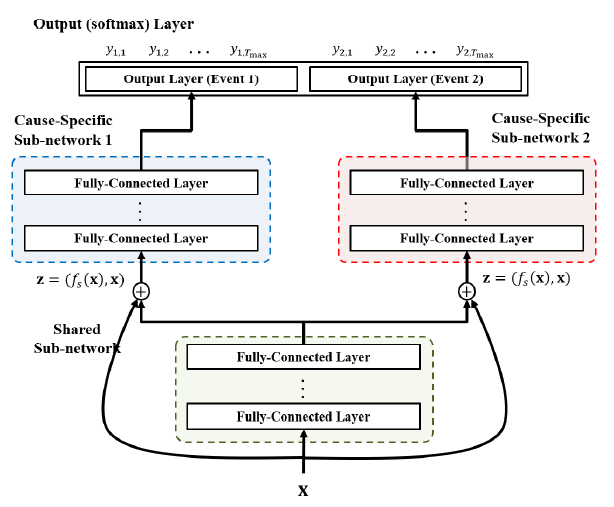

In [ ]:
class DeepHit(Model):
  def __init__(self, input_dims, network_settings, **kwargs):
    super().__init__(**kwargs) 
    
    # INPUT DIMENSIONS      
    #   - x_dim: dimension of features
    #   - num_Event: number of competing events (this does not include censoring label)
    #   - num_TimeBucket: dimension of time horizon of interest, i.e., |T| where T = {0, 1, ..., T_max-1} 
    self.x_dim = input_dims['x_dim']
    self.num_Event = input_dims['num_Event']
    self.num_Category = input_dims['num_Category']

    # NETWORK HYPER-PARAMETERS
    #   - h_dim_shared & num_layers_shared: number of nodes and number of fully-connected layers for the shared subnetwork
    #   - h_dim_CS & num_layers_CS: number of nodes and number of fully-connected layers for the cause-specific subnetworks
    #   - active_fn: 'relu', 'elu', 'tanh'
    #   - initial_W: Xavier initialization is used as a baseline
    self.h_dim_shared = network_settings['h_dim_shared']
    self.h_dim_CS = network_settings['h_dim_CS']
    self.active_fn = network_settings['active_fn']
    self.initial_W = network_settings['initial_W']

    self.SharedSubNetwork = keras.layers.Dense(self.h_dim_shared, activation = self.active_fn, kernel_initializer= self.initial_W)
    self.dropout1 = keras.layers.Dropout(0.3)
    self.concat = keras.layers.Concatenate()
    
    self.CSSubNetwork_l1 = keras.layers.Dense(self.h_dim_CS*2, activation = self.active_fn, kernel_initializer= self.initial_W)
    self.dropout2 = keras.layers.Dropout(0.3)
    self.CSSubNetwork_l2 = keras.layers.Dense(self.h_dim_CS, activation = self.active_fn, kernel_initializer= self.initial_W)
    self.dropout3 = keras.layers.Dropout(0.3)

    self.OutputLayer = keras.layers.Dense(self.num_Event * self.num_Category, activation = 'softmax')

  def call(self, inputs, training = False):
    fs = self.SharedSubNetwork(inputs)
    if training:
      fs = self.dropout1(fs)
    z = self.concat([fs, inputs])

    out = []
    for _ in range(self.num_Event):
      cs_out = self.CSSubNetwork_l1(z)
      if training:
        cs_out = self.dropout2(cs_out)
      cs_out = self.CSSubNetwork_l2(cs_out)
      if training:
        cs_out = self.dropout3(cs_out)
      out.append(cs_out)
    
    out = tf.stack(out, axis=1)
    out = tf.reshape(out, [-1, self.num_Event*self.h_dim_CS])
    out = self.OutputLayer(out)
    out = tf.reshape(out, [-1, self.num_Event, self.num_Category])
    return out

**Loss Function**

In [ ]:
def loss_total(mask1, y_pred, k, t,mask2, alpha):

  return loss_Log_Likelihood(mask1, y_pred, k) + alpha * loss_Ranking(mask2, y_pred, k, t) + 0.5*smoothing(y_pred)

def loss_Log_Likelihood(mask1, y_pred, k):
  I_1 = tf.sign(k)
  I_1 = tf.cast(I_1, dtype = tf.float32)
  mask1 = tf.cast(mask1, dtype = tf.float32)  

  #for uncenosred: log P(T=t,K=k|x)
  tmp1 = tf.reduce_sum(tf.reduce_sum(mask1 * y_pred, axis=2), axis=1, keepdims=True)
  tmp1 = I_1 * log(tmp1)
    
  #for censored: log \sum P(T>t|x)
  tmp2 = tf.reduce_sum(tf.reduce_sum(mask1 * y_pred, axis=2), axis=1, keepdims=True)
  tmp2 = (1. - I_1) * log(tmp2)

  return - tf.reduce_mean(tmp1 + 1.0*tmp2)

def loss_Ranking(mask2, y_pred, k, t):
  sigma1 = tf.constant(0.1, dtype=tf.float32)
  mask2 = tf.cast(mask2, dtype = tf.float32)
  t = tf.cast(t, dtype = tf.float32)

  eta = []
  for e in range(num_Event):
    one_vector = tf.ones_like(t, dtype=tf.float32)
    I_2 = tf.cast(tf.equal(k, e+1), dtype = tf.float32) #indicator for event
    I_2 = tf.linalg.diag(tf.squeeze(I_2))
    tmp_e = tf.reshape(tf.slice(y_pred, [0, e, 0], [-1, 1, -1]), [-1, num_Category]) #event specific joint prob.

    R = tf.matmul(tmp_e, tf.transpose(mask2)) #no need to divide by each individual dominator
    # r_{ij} = risk of i-th pat based on j-th time-condition (last meas. time ~ event time) , i.e. r_i(T_{j})

    diag_R = tf.reshape(tf.linalg.diag_part(R), [-1, 1])
    R = tf.matmul(one_vector, tf.transpose(diag_R)) - R # R_{ij} = r_{j}(T_{j}) - r_{i}(T_{j})
    R = tf.transpose(R)                                 # Now, R_{ij} (i-th row j-th column) = r_{i}(T_{i}) - r_{j}(T_{i})

    T = tf.nn.relu(tf.sign(tf.matmul(one_vector, tf.transpose(t)) - tf.matmul(t, tf.transpose(one_vector))))
    # T_{ij}=1 if t_i < t_j  and T_{ij}=0 if t_i >= t_j

    T = tf.matmul(I_2, T) # only remains T_{ij}=1 when event occured for subject i

    tmp_eta = tf.reduce_mean(T * tf.exp(-R/sigma1), axis=1, keepdims=True)

    eta.append(tmp_eta)
    eta = tf.stack(eta, axis=1) #stack referenced on subjects
    eta = tf.reduce_mean(tf.reshape(eta, [-1, num_Event]), axis=1, keepdims=True)

    return tf.reduce_sum(eta) #sum over num_Events

In [ ]:
def smoothing(y_pred):

  #tau = tf.reduce_sum(tf.reduce_mean(y_pred, axis=0),axis=0)
  tau = tf.reduce_mean(y_pred, axis=0)
  if tau[1,num_Category-1] > 3.0* tau[1,num_Category-2]:
    excess = tau[1,num_Category-1] - 3.0*tau[1,num_Category-2]
  else:
    excess = 0.0
  
  excess = excess + tf.math.abs(tau[1,num_Category-2]-tau[1,num_Category-3]) + tf.math.abs(tau[1,num_Category-3]-tau[1,num_Category-4]) + tf.math.abs(tau[1,num_Category-4]-tau[1,num_Category-5]) + tf.math.abs(tau[1,num_Category-5]-tau[1,num_Category-6]) + tf.math.abs(tau[0,num_Category-1]-tau[0,num_Category-2]) + tf.math.abs(tau[0,num_Category-2]-tau[0,num_Category-3]) + tf.math.abs(tau[0,num_Category-3]-tau[0,num_Category-4])

  return excess

# III. Training

In [ ]:
input_dims = {'x_dim': x_dim,
              'num_Event': num_Event,
              'num_Category': num_Category}

network_settings = {'h_dim_shared':64,
                    'h_dim_CS':64,
                    'active_fn': 'relu',
                    'initial_W': 'glorot_normal'}

model = DeepHit(input_dims, network_settings)

optimizer = keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((tr_data, tr_time, tr_label, tr_mask1, tr_mask2))
test_dataset = tf.data.Dataset.from_tensor_slices((te_data, te_time, te_label, te_mask1, te_mask2))

batch_size = 128
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

alpha = 0.3
epochs = 20
for epoch in range(epochs):
  print("\nStart of epoch %d" % (epoch,))

  # Iterate over the batches of the dataset.
  losses=[]
  for step, (x_batch_train, s_batch_train, k_batch_train, y_batch_train, mask2_batch_train) in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      y_pred = model(x_batch_train, training = True)
      loss_value = loss_total(y_batch_train, y_pred, k_batch_train, s_batch_train, mask2_batch_train, alpha) 
      
    gradients = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    losses.append(loss_value)

  losses_mean = np.mean(losses)
  print('Loss = {}'.format(losses_mean))

  val_losses=[]
  for x_batch_val, s_batch_val, k_batch_val, y_batch_val, mask2_batch_val in test_dataset:
    val_y_pred = model(x_batch_val)
    val_loss = loss_total(y_batch_val, val_y_pred, k_batch_val, s_batch_val, mask2_batch_val, alpha)
    val_losses.append(val_loss)
  
  val_losses_mean = np.mean(val_losses)
  print('Validation Loss = {}'.format(val_losses_mean))


# IV. Sample Model Output



In [ ]:
def calcSurv(tau_dist):
  surv = 1.0 - tau_dist.cumsum(axis=-1)
  surv = np.insert(surv, 0, 1.0, axis=-1)
  surv = np.delete(surv, surv.shape[-1]-1, axis=-1)
  return surv

def calcMonthlyTermRate(termination_rate):
  time_steps = np.ones_like(termination_rate)
  time_steps[:,:,8:]=12
  time_steps[:,:,0:8]=3
  return termination_rate / time_steps

In [ ]:
df_sample = df.sample(2)
df_sample[['GNDR','YR_OF_ISSUE','CLM_INCUR_YR','Incur_Age','BENEFIT_PAYMENT_TYPE',
           'OrigDiagnosis_Alzheimer’s and Dementia','OrigDiagnosis_Cancer','OrigDiagnosis_Circulatory','OrigDiagnosis_Injury',
           'OrigDiagnosis_Nervous System','OrigDiagnosis_Other','OrigLevelofCare_1','OrigLevelofCare_2','OrigLevelofCare_3',
           'TerminationReason','Time_of_Event']].head()

In [ ]:
data_sample = np.asarray(df_sample.iloc[:,:-2])
data_sample = scaler.transform(data_sample)
y_test_sample = model.predict(data_sample)

x = ['q1','q2','q3','q4','q5','q6','q7','q8','Y3','Y4','Y5','Y6','Y7','Y8','Y9','Y10','Y11','Y12','Y13','Y14','Y15']

f, (ax1, ax2) = plt.subplots(2, 1, sharey='col')
ax1.plot(x,y_test_sample[0,0,:], label = 'Recovery',marker = 'o')
ax1.plot(x,y_test_sample[0,1,:], label = 'Death',marker = 'o')
ax1.set_ylabel('Prob of Termination', axes=ax1)
ax1.set_ylim((0.0,0.25))

ax2.plot(x,y_test_sample[1,0,:], label = 'Recovery',marker = 'o')
ax2.plot(x,y_test_sample[1,1,:], label = 'Death',marker = 'o')
ax2.set_xlabel('Claim Duration', axes=ax2)
ax2.set_ylabel('Prob of Termination', axes=ax2)
plt.legend()

f.suptitle('Termination Distribution')

tau_distribution = y_test_sample.sum(axis=1, keepdims=True)
surv = calcSurv(tau_distribution)
termination_rate = y_test_sample / surv
termination_rate_monthly = calcMonthlyTermRate(termination_rate)

f, (ax1, ax2) = plt.subplots(2, 1, sharey='col')
ax1.plot(x,termination_rate_monthly[0,0,:], label = 'Recovery')
ax1.plot(x,termination_rate_monthly[0,1,:], label = 'Death')
ax1.plot(x,termination_rate_monthly.sum(axis=1)[0], label = 'Total', marker = 'o', color = 'g')
ax1.set_ylabel('Termination Rate', axes=ax1)
ax1.set_ylim((0.0,0.1))

ax2.plot(x,termination_rate_monthly[1,0,:], label = 'Recovery')
ax2.plot(x,termination_rate_monthly[1,1,:], label = 'Death')
ax2.plot(x,termination_rate_monthly.sum(axis=1)[1], label = 'Total', marker = 'o', color = 'y')
ax2.set_xlabel('Claim Duration', axes=ax2)
ax2.set_ylabel('Monthly Termination Rate', axes=ax2)
plt.legend()

f.suptitle('Monthly Termination Rates')

f, ax1 = plt.subplots(1, 1, sharey='col')
ax1.plot(x, surv[0,0,:], label = 'Claim 1', marker = 'o', color = 'g')
ax1.plot(x, surv[1,0,:], label = 'Claim 2', marker = 'o', color = 'y')
ax1.set_xlabel('Time')
ax1.set_ylabel('Survivorship')
plt.legend()
f.suptitle('Claim Continuation')

# V. Model Evaluation

## **A. Concordance Index**

For discriminative performance

Fitted survival models typically have a concordance index between 0.55 and 0.75.

[Add benchmarking to other models]

In [ ]:
def c_index(Prediction, Time_survival, Death, Time):
    '''
        This is a cause-specific c(t)-index
        - Prediction      : risk at Time (higher --> more risky)
        - Time_survival   : survival/censoring time
        - Death           :
            > 1: death
            > 0: censored (including death from other cause)
        - Time            : time of evaluation (time-horizon when evaluating C-index)
    '''
    N = len(Prediction)
    A = np.zeros((N,N))
    Q = np.zeros((N,N))
    N_t = np.zeros((N,N))
    Num = 0
    Den = 0
    for i in range(N):
        A[i, np.where(Time_survival[i] < Time_survival)] = 1
        Q[i, np.where(Prediction[i] > Prediction)] = 1
  
        if (Time_survival[i]<=Time and Death[i]==1):
            N_t[i,:] = 1

    Num  = np.sum(((A)*N_t)*Q)
    Den  = np.sum((A)*N_t)

    if Num == 0 and Den == 0:
        result = -1 # not able to compute c-index!
    else:
        result = float(Num/Den)

    return result

In [ ]:
pred = model.predict(te_data)

EVAL_TIMES = [4, 8, 9, 10, 16]
result = np.zeros([num_Event, len(EVAL_TIMES)])
for t, t_time in enumerate(EVAL_TIMES):
  eval_horizon = int(t_time)
  risk = np.sum(pred[:,:,:(eval_horizon+1)], axis=2)
  
  for k in range(num_Event):
    result[k, t] = c_index(risk[:,k], te_time, (te_label[:,0] == k+1).astype(float), eval_horizon)

result

## **B. Actual Vs Expected Termination Rates**

In [ ]:
def exposure_mask(tau):
  mask = [1 if i <= int(tau) else 0 for i in range(num_Category)]
  return np.array(mask)

def termination_mask(k, tau):
    mask = np.zeros([num_Event, num_Category])
    if k != 0:  #not censored
      mask[int(k-1),int(tau)] = 1
    return mask

In [ ]:
df_test = df.loc[te_claimID]

origDiagnosis = ["OrigDiagnosis_Alzheimer’s and Dementia"	,"OrigDiagnosis_Cancer",	"OrigDiagnosis_Circulatory",
               "OrigDiagnosis_Injury","OrigDiagnosis_Nervous System","OrigDiagnosis_Other"]
OrigDiagnosis = df_test[origDiagnosis]
df_test['ORIGINAL_PRECIPITATING_ICD9_OR_ICD10_DIAGNOSIS'] = OrigDiagnosis.idxmax(axis=1).str[14:]
df_test.drop(origDiagnosis,axis=1,inplace=True)

origLevelofCare = ['OrigLevelofCare_1','OrigLevelofCare_2','OrigLevelofCare_3']
OrigLevelofCare = df_test[origLevelofCare]
df_test['ORIGINAL_LEVEL_OF_CARE_FOR_THIS_CLAIM'] = OrigLevelofCare.idxmax(axis=1).str[-1]
df_test.drop(origLevelofCare,axis=1,inplace=True)

df_test['AgeBand'] = pd.cut(df_test['Incur_Age'],[0,65,70,75,80,85,95], right=False,
                            labels=['<65','65-69','70-74','75-79','80-84','85+'])

df_test['EraBand'] = pd.cut(df_test['YR_OF_ISSUE'],[0,1990,1995,2000,2005,2015], right=False,
                            labels=['<1990','1990-94','1995-99','2000-04','2005+'])

df_test['Pred'] = pred.tolist()
df_test['k_dist'] = df_test['Pred'].apply(lambda x: np.array(x).sum(axis=1))
df_test['tau_dist'] = df_test['Pred'].apply(lambda x: np.array(x).sum(axis=0))

df_test['exposure'] = df_test.apply(lambda x: exposure_mask(x['Time_of_Event']), axis=1)
df_test['term_mask'] = df_test.apply(lambda x: termination_mask(x['TerminationReason'],x['Time_of_Event']), axis=1)

df_test.sample(5)

In [ ]:
actual_term_rate = np.array(df_test['term_mask']).sum() / np.array(df_test['exposure']).sum()

expected_distribution = df_test.apply(lambda x: np.array(x['Pred']), axis=1).mean()
surv = calcSurv(expected_distribution.sum(axis=0))
expected_term_rate = expected_distribution / surv

f, ax1 = plt.subplots(1, 1, sharey='col')
ax1.plot(x[:-1], actual_term_rate[0,:-1], label = 'Actual', marker = 'o')
ax1.plot(x[:-1], expected_term_rate[0,:-1], label = 'Expected', marker = 'o')
ax1.set_xlabel('Time (Claim Duration)')
ax1.set_ylabel('Termination Rate')
plt.legend()
ax1.set_ylim((0.0,0.4))
f.suptitle('Recovery Rate')

f, ax1 = plt.subplots(1, 1, sharey='col')
ax1.plot(x[:-1], actual_term_rate[1,:-1], label = 'Actual', marker = 'o')
ax1.plot(x[:-1], expected_term_rate[1,:-1], label = 'Expected', marker = 'o')
ax1.set_xlabel('Time (Claim Duration)')
ax1.set_ylabel('Termination Rate')
plt.legend()
ax1.set_ylim((0.0,0.4))
f.suptitle('Mortality Rate')

In [ ]:
expected_distribution

In [ ]:
actual_term = np.array(df_test['term_mask']).sum()
actual_term

In [ ]:
actual_exposure = np.array(df_test['exposure']).sum()
actual_exposure

# VI. Additional Analytics

This section analyzes, through aggregation and slicing and dicing of the model results, to gain more insights into what the model learned from the data

In [ ]:
def analyze_claim(g):
  g_surv = g.apply(lambda subf: np.array(subf['tau_dist']).mean())
  g_surv = g_surv.apply(lambda y: calcSurv(np.array(y)))
  
  plt.figure()
  for index, value in g_surv.items():
    plt.plot(x,value, label = index)
  plt.title('Claim Continuation')
  plt.legend()
  plt.show()

  print('\nCause of Termination Distribution [Recovery, Death]:')
  print(g.apply(lambda subf: np.array(subf['k_dist']).mean()))

### *By Incur Age*
- Younger incurred age tend to recover quickly
- Mortality becomes dominant termination factor in later durations

In [ ]:
g = df_test.groupby('AgeBand')
analyze_claim(g)

### *By Gender*
Female tend to stay on claims longer


In [ ]:
g = df_test[df_test['GNDR']!=0].groupby('GNDR')
print('1 = Female; 2 = Male')

analyze_claim(g)

### *By Original Precipitating ICD9 or ICD10 Diagnosis*
- People with cancer tend to stay on claims much shorter than other diseases, and more likely to terminate due to death
- People with Alzheimer’s and Dementia tend to stay on claims longer, due to lower chances of recovery
- People with Injury tend to have high recovery rate early.  However, if recovery does not happen early, it becomes unlikely

In [ ]:
g = df_test.groupby('ORIGINAL_PRECIPITATING_ICD9_OR_ICD10_DIAGNOSIS')
analyze_claim(g)

### *By Original Level of Care*

People in Assisted Living Facility tend to have low recovery rate and stay on claim longer, this may be partly explained by Assisted Living Facility having higer percentage of 'Alzheimer’s and Dementia' patients  (~50%, compared to ~24% for NH and Home Care), and lower percentage of 'Cancer' patients (3%, versus 13% for NH and Home Care).


In [ ]:
g = df_test.groupby('ORIGINAL_LEVEL_OF_CARE_FOR_THIS_CLAIM')
print('0 = Unknown; 1 = Nursing Facility; 2 = Assisted Living Facility; 3 = Home Care')

analyze_claim(g)

In [ ]:
g = df_test.groupby(['ORIGINAL_LEVEL_OF_CARE_FOR_THIS_CLAIM','ORIGINAL_PRECIPITATING_ICD9_OR_ICD10_DIAGNOSIS']).size()
g/g.groupby(level=0).sum()

### *By Cognitive_Impairment*

The probability of recovering from cognitive impairement is low, and those claims tend to last longer 

In [ ]:
g = df_test.groupby('COGNITIVE_IMPAIRMENT')
print('0 = Unknown; 1 = Yes; 2 = No')

analyze_claim(g)

### *By Issue Year*

[Check potential left censored issue]

In [ ]:
g = df_test.groupby('EraBand')

analyze_claim(g)

In [ ]:
g.size()
g['Incur_Age'].mean()

In [ ]:
g = df_test.groupby(['EraBand','ORIGINAL_PRECIPITATING_ICD9_OR_ICD10_DIAGNOSIS']).size()
g/g.groupby(level=0).sum()

# References

* Changhee Lee, William R. Zame, Jinsung Yoon, Mihaela van der Schaar. "DeepHit: A Deep Learning Approach to Survival Analysis with Competing Risks". 2018 http://medianetlab.ee.ucla.edu/papers/AAAI_2018_DeepHit  
* Laura Löschmann, Daria Smorodina. "Deep Learning for Survival Analysis". 2020 https://humboldt-wi.github.io/blog/research/information_systems_1920/group2_survivalanalysis/
* What is Harrell’s C-index? https://statisticaloddsandends.wordpress.com/2019/10/26/what-is-harrells-c-index/